#### Change the path if necessary.

In [1]:
import findspark
findspark.init('/home/peyman/spark-2.0.0-bin-hadoop2.7')

#### Let's import the libraries that we want to use.

In [2]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
import time
import datetime
import pandas as pd
from operator import add

#### Create a local StreamingContext with two working thread and batch interval of 10 second

In [3]:
sc = SparkContext()
ssc = StreamingContext(sc,10)
sqlContext = SQLContext(sc)

In [4]:
ssc.checkpoint("The most popular Tweeter hashtag by track")

#### Create a DStream that will connect to my local machine and port.

In [5]:
socket_stream = ssc.socketTextStream("127.0.0.1", 5593)

#### Lets create new DStreams in which each RDD contains all the elements in seen in a sliding window of 30 seconds over this DStream.

In [6]:
lines = socket_stream.window(30)

#### The following function will put together the tweets and counts in the above DStreams of 30 seconds.

In [7]:
def aggregate_tags_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

#### We need to extract tuples of hashtags and counts.

In [8]:
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [9]:
# Lets split the words from each tweet.
words = lines.flatMap(lambda text: text.split(" "))

# We convert each word to lower case therefore hashtags such as
# Football and #football will be treated the same.

wordsLowerCase = words.map(lambda word: word.lower())

# Lets filter the words that start with a hashtag.

hashtags = wordsLowerCase.filter(lambda word: word.startswith("#"))

# We map the hashtags to tuples of the form (hashtag,1) in order to count them.

hashtagsMapped = hashtags.map(lambda x: (x,1))

hashtagsMappedReduced = hashtagsMapped.reduceByKey(add)

# We sum up all of the counts of a hashtag from the time that we started
# streaming.

hashtagsMappedReducedUpdated = hashtagsMappedReduced.updateStateByKey(aggregate_tags_count)

# Lets prepare the data to sit in a dataframe so we can have SQL queries.

TagCount = hashtagsMappedReducedUpdated.map(lambda rec: Tweet(rec[0], rec[1] ))

#### Using the below line, we let the updated (tag, count) sit in a temporary table.

In [10]:
TagCount.foreachRDD(lambda rdd: rdd.toDF().sort(desc("count")).limit(10).registerTempTable("tweets"))

#### We start streaming.

In [11]:
ssc.start()

#### In order to let the tweets stream, we need to let the file TweetRead.py activate and also we need to mention the track in the terminal so in a fresh terminal we need to mention python TweetRead.py Football as an example.

#### Moreover, we need to have 30 seconds sleep since we need to have our temporary table get started which takes 30 seconds from the start time.

In [12]:
time.sleep(30)

----------------------------------------------
2018-12-31 09:37:46.678650
----------------------------------------------


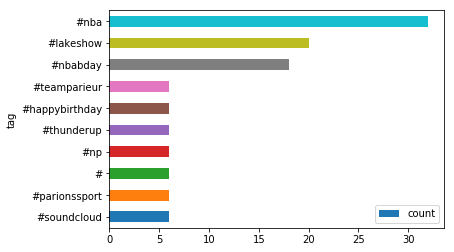

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import sys
from IPython.display import clear_output   # Lets clear the output so we see the most popular
                                           # hashtag from the time the we started streaming.  
for i in range(100):
    print "----------------------------------------------"
    print str(datetime.datetime.utcnow())
    print "----------------------------------------------"
    df = sqlContext.sql("SELECT * FROM tweets ORDER BY count ASC").toPandas()
    df["count"] = pd.to_numeric(df["count"])    
    df.plot(x="tag", y="count", kind="barh")
    plt.pause(25)
    clear_output()